In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from synexp import *
from viz import *

/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Experimental setup:
- $X \in [-1,1]$
- $\eta^*_d(x)$ sinusoidal function
- $\pi(x)$ linear and correlated with $\eta^*_0(x)$


## Experiments

#### Primary: model comparision
- $\hat{P}[Y=1|X=x]$ (naive observational)
- $\hat{P}_{\ell}[Y=1|D=d,X=x]$ (conditional outcome)
- $\hat{P}_{\tilde{\ell}}[Y=1|D=d,X=x]$ (**ours:** conditional outcome with surrogate loss)
- $\hat{P}[Y_d=1|X=x]$ (proxy PO oracle)
- $\hat{P}[Y^*_d=1|X=x]$ (target PO oracle)

#### Primary: Parameter estimation experiment (test of CCPE approach)
- Compare bias in parameter estimates as a function of sample size $Ns = [1k, 2k, ..., 20k]$
- Show that non-random decisions (non-uniform $\pi$) introduces more bias in $\alpha$ or $\beta$

#### Primary: robustness to parameter estimation error
- Evaluate how conditional outcome model performance deteriorates as a function of parameter estimation error
- Vary magnitude of error terms

#### Appendix: Conditional outcome model performance as a function of measurement error
- Vary measurement error parameters and see how optimizing "naive" loss performs






In [8]:
generate_syn_data_multioutcome(
    NS=8000,
    K=3,
    y0_pdf='low_base_rate_sinusoid',
    y1_pdf='sinusoid',
    pi_pdf='linear',
    error_min=0.05,
    error_max=0.25)

NameError: name 'eta' is not defined

In [2]:
Y0_PDF = 'sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'

# Example code invoking experiemnt setup functions
expdf_Y1, error_params = generate_syn_data(
    NS=5000,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.05,
    error_max=0.25
)
# Sanity check
# results, val_scores = run_baseline_comparison_exp(expdf, do=0,
#                                            error_params=error_params, n_epochs=20, train_ratio=.7)

In [1]:
def ccpe(expdf, do, n_epochs):

    # Don't need error params for surrogate at this stage
    error_params = {
        'alpha': None,
        'beta': None
    }
    
    expdf = expdf.sample(frac=1).reset_index(drop=True)
    expdf = expdf[expdf['D'] == do]
    split_ix = int(expdf.shape[0]*.7)
    train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]

    train_loader, val_loader = get_loaders(train_df, val_df, do, target='Y')
    model = MLP()
    losses = train(model, 'Y|D', train_loader, error_params=error_params, n_epochs=n_epochs)
    x, y, py_hat = evaluate(model, val_loader)
    
    # Compute error parameters from predicted probabilities
    alpha_hat = py_hat.min()
    beta_hat = 1 - py_hat.max()

    debug_info = {
        'val_x': val_df['X'].to_numpy(),
        'val_py': py_hat
    }
    
    return alpha_hat, beta_hat, debug_info

## Experiment 1: Validating factual surrogate loss correction

In [3]:
do=0
baselines = [{
    'model': 'Observational',
    'target': 'Y'
},{
    'model': 'Conditional outcome',
    'target': 'Y'
},{
    'model': 'Conditional outcome (SL)',
    'target': 'Y'
},{
    'model': 'Proxy PO Oracle',
    'target': f'Y_{do}'
},{
    'model': 'Target PO Oracle',
    'target': f'YS_{do}'
}]

exp_results = run_baseline_comparison_exp(baselines, do=do,
                                          N_RUNS=5, NS=8000, n_epochs=20)
resultdf = pd.DataFrame(exp_results)

Target: YS_0: 100%|█████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Observational'),
  Text(1, 0, 'Conditional outcome'),
  Text(2, 0, 'Conditional outcome (SL)'),
  Text(3, 0, 'Proxy PO Oracle'),
  Text(4, 0, 'Target PO Oracle')])

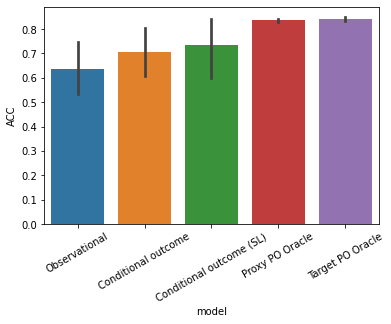

In [8]:
sns.barplot(data=resultdf, x='model', y='ACC')
plt.xticks(rotation=30)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Observational'),
  Text(1, 0, 'Conditional outcome'),
  Text(2, 0, 'Conditional outcome (SL)'),
  Text(3, 0, 'Proxy PO Oracle'),
  Text(4, 0, 'Target PO Oracle')])

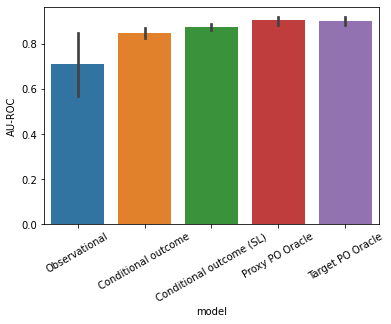

In [10]:
sns.barplot(data=resultdf, x='model', y='AU-ROC')
plt.xticks(rotation=30)

## Main exp: parameter estimation via CCPE

In [13]:
N_RUNS = 3
results = []
SAMPLE_SIZES = [2000, 4000, 6000, 8000, 10000, 20000]

for NS in SAMPLE_SIZES:
    for RUN in range(N_RUNS):
        expdf, error_params = generate_syn_data(
            NS,
            y0_pdf=Y0_PDF,
            y1_pdf=Y1_PDF,
            pi_pdf=PI_PDF,
            error_min=0.05,
            error_max=0.25
        )
        exp_result = run_param_estimation_exp(expdf, error_params, n_epochs=20)    
        results.append(exp_result)


Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:12<00:00,  1.59it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:11<00:00,  1.68it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:11<00:00,  1.74it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:11<00:00,  1.76it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:12<00:00,  1.62it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:12<00:00,  1.64it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:13<00:00,  1.52it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:12<00:00,  1.58it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:13<00:00,  1.52it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:13<00:00,  1.53it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:12<00:00,  1.62it/s]
Target p[Y|D|X]: 100%|██████████████████████████| 20/20 [00:11<00:00,  1.70it/s]
Target p[Y|D|X]: 100%|██████

<AxesSubplot:xlabel='NS', ylabel='beta_0_error'>

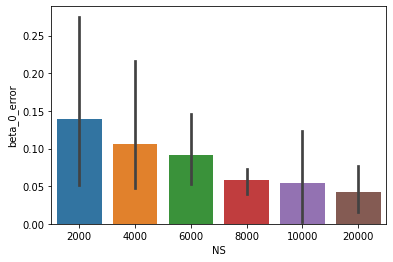

In [17]:

estimation_df = pd.DataFrame(results)
sns.barplot(data=estimation_df, x='NS', y='beta_0_error')

In [ ]:
def run_estimation_error_exp(expdf, do, error_params, n_epochs=5, train_ratio=.7):

    expdf = expdf.sample(frac=1).reset_index(drop=True)
    split_ix = int(expdf.shape[0]*train_ratio)
    train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]
    
    exp_results = {
        'noise_rate': [],
        'AU-ROC': []
    }

    param_configs = [{
        'alpha': .01,
        'beta': .01
    },{
        'alpha': .05,
        'beta': .05
    },{
        'alpha': .1,
        'beta': .1
    },{
        'alpha': .25,
        'beta': .24
    }]
    
    targets = ['YD']
    val_scores = {}
    
    for surrogate_params in param_configs:
        
        train_loader, val_loader = get_loaders(train_df, val_df, do, target)
        model = MLP()
        losses = train(model, train_loader, error_params=surrogate_params, n_epochs=n_epochs)
        x, y, py_hat = evaluate(model, val_loader)
        auroc = roc_auc_score(y, py_hat)

        exp_results['noise_rate'].append(surrogate_params['alpha']+surrogate_params['beta'])
        exp_results['AU-ROC'].append(auroc)
        
        val_scores[target] = {}
        val_scores[target]['x'] = x
        val_scores[target]['y'] = y
        val_scores[target]['py_hat'] = py_hat

    return exp_results, val_scores

run_estimation_error_exp(expdf, do, error_params,
                         n_epochs=5, train_ratio=.7)

sns.barplot(data=resultdf, x='model', y='AU-ROC')

## Visualize class probability estimates

Target: YS_0: 100%|█████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


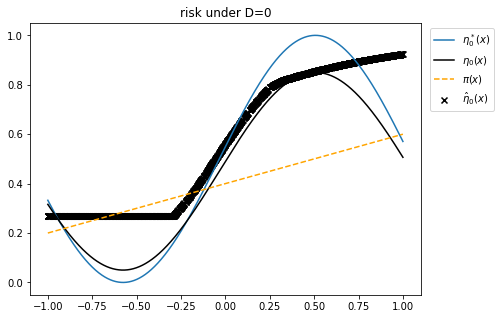

In [19]:
params = { 'alpha': None, 'alpha_0': .05, 'beta': None, 'beta_0': .15 }
baseline = {
    'model': 'Target PO Oracle',
    'target': 'YS_0'
    
}

results = run_baseline(expdf, baseline, do, params,
             n_epochs=10, train_ratio=.7)

do=0
debug_info = {
    'val_x': results['x'],
    'val_py': results['py_hat']
}

viz_ccpe_estimates(expdf, debug_info, params, do, Y0_PDF, Y1_PDF, PI_PDF)
